In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [20]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [6]:
discipline = "Pharmacology & Pharmacy"

In [7]:
foo = data_grouped_by_year_label[["Label"]].groupby(data_grouped_by_year_label.Label).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
foo.head(30)


,Label,counts
248,Zoology,117
87,Evolutionary Biology,117
33,"Chemistry, Inorganic & Nuclear",117
85,Ethics,117
35,"Chemistry, Multidisciplinary",117
139,"Materials Science, Multidisciplinary",117
201,Psychology,117
39,Clinical Neurology,117
200,Psychiatry,117
197,Political Science,117


In [8]:
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [9]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words
14463,14463,Pharmacology & Pharmacy,1900,"[experimental siderosis, experimental siderosi...","[secret public alien asylum, information pharm...",secret public alien asylum information pharmac...,secret public alien asylum information pharmac...
14464,14464,Pharmacology & Pharmacy,1901,"[sensousness cruelty religion, sensousness ...",[crowd madness contribution study epidemic ma...,crowd madness contribution study epidemic mad...,crowd madness contribution study epidemic madn...
14465,14465,Pharmacology & Pharmacy,1902,[protection assests sick institution alienated...,[demonstration decomposition chloroforms light...,demonstration decomposition chloroforms lights...,demonstration decomposition chloroforms lights...
14466,14466,Pharmacology & Pharmacy,1903,[from medical clinic tuebingen information alb...,"[alloxuria bodies metabolism leukaemia , varia...",alloxuria bodies metabolism leukaemia variati...,alloxuria bodies metabolism leukaemia variatio...
14467,14467,Pharmacology & Pharmacy,1904,[study effect diphtheric toxin body temperatur...,[modifications toxicity certain poisons additi...,modifications toxicity certain poisons additio...,modifications toxicity certain poisons additio...


In [10]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

In [11]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

In [12]:
vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [13]:
vectorized_wordarray.shape

(117, 240255)

In [14]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:01<00:00, 82.12it/s] 


In [15]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

__Frequency Variations:__ Words which have a frequency of 20 in year Y<sub>t</sub>. How much do they normally vary in years Y<sub>t+1</sub>, t<sub>t+2</sub> etc. 

In [16]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
#         if index == 49 and uniq == 12:
#             import ipdb
#             ipdb.set_trace()
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:04<00:00, 28.03it/s]


In [17]:
len(yearly_word_frequency_variations)

116

__Word Frequency Variations Plot | Year__

__Year:__ 2011

In [18]:
input_.iloc[111:112]

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
14574,14574,Pharmacology & Pharmacy,2011,[alpha beta unsaturated carbonyl system chalco...,[discovery 6 2 4 difluorophenoxy 2 3 hydroxy...,discovery 6 2 4 difluorophenoxy 2 3 hydroxy ...,discovery difluorophenoxy hydroxy hydroxyethyl...,81005,454141


Total count of papers: 42160
Total count of words: 400963

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2536 words with 3 counts
2731 words with 3 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


2601 words with 3 counts
2607 words with 3 counts
2706 words with 3 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


2682 words with 3 counts


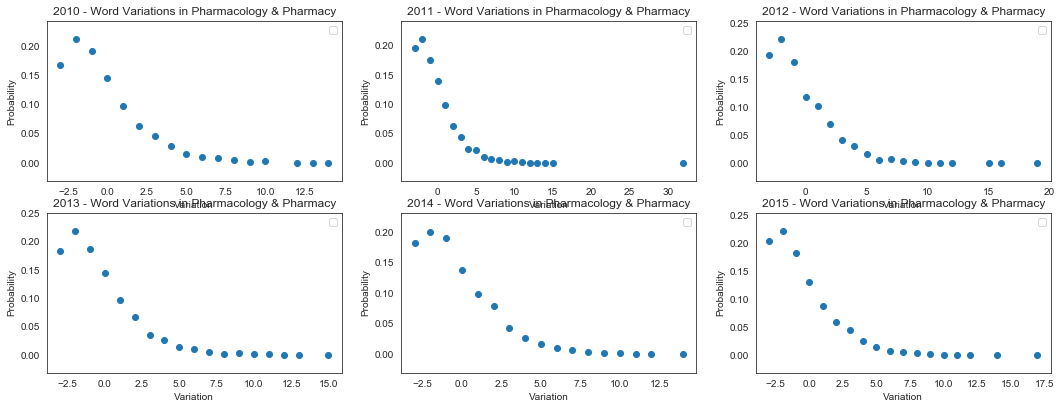

In [21]:
K = 3
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


1085 words with 5 counts
1163 words with 5 counts
1192 words with 5 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1204 words with 5 counts
1185 words with 5 counts
1284 words with 5 counts


No handles with labels found to put in legend.


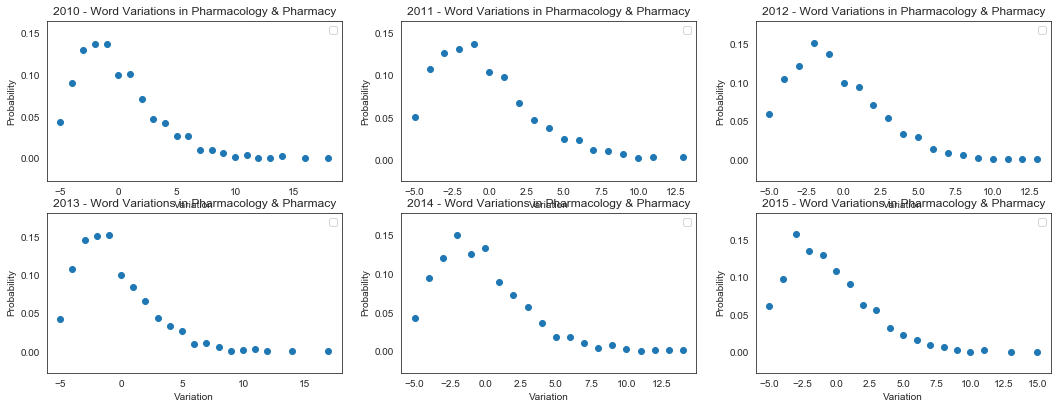

In [22]:
K = 5
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


732 words with 7 counts
695 words with 7 counts
684 words with 7 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


750 words with 7 counts
710 words with 7 counts
725 words with 7 counts


No handles with labels found to put in legend.


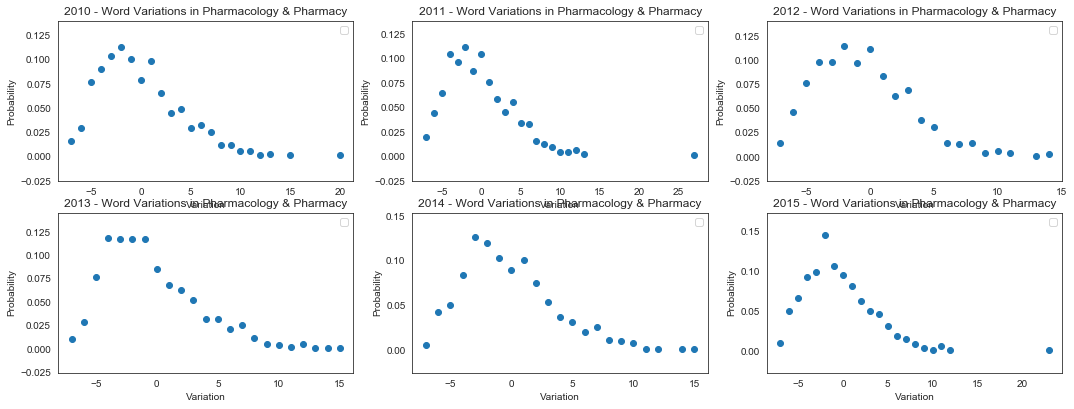

In [23]:
K = 7
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

396 words with 10 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


399 words with 10 counts
388 words with 10 counts
385 words with 10 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


403 words with 10 counts
391 words with 10 counts


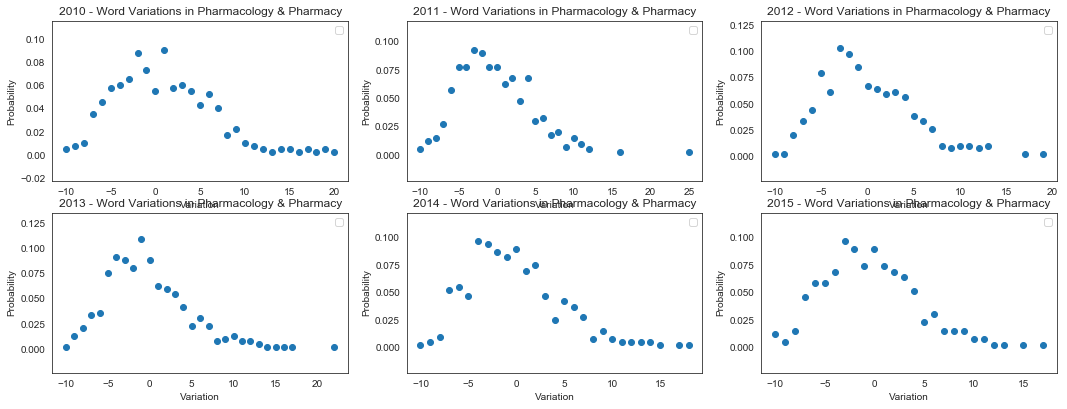

In [24]:
K = 10
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


182 words with 15 counts
221 words with 15 counts
194 words with 15 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


207 words with 15 counts
205 words with 15 counts


No handles with labels found to put in legend.


215 words with 15 counts


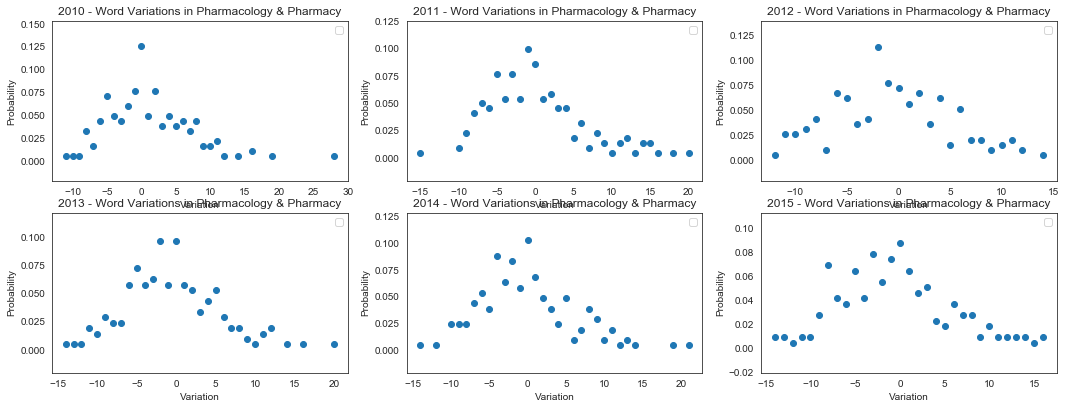

In [25]:
K = 15
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

In [29]:
counts_ = dict(Counter(variations)).values()
counts_

dict_values([12, 15, 9, 1, 6, 10, 13, 3, 8, 9, 8, 2, 5, 2, 1, 11, 7, 3, 5, 2, 2, 1, 1, 1])

In [27]:
len(indices)

137

No handles with labels found to put in legend.


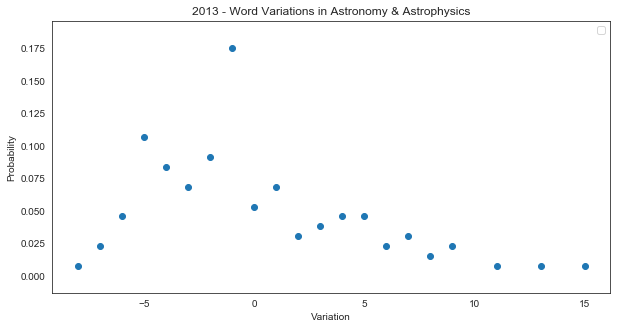

In [32]:
year = 2013

N = 112
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  


f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


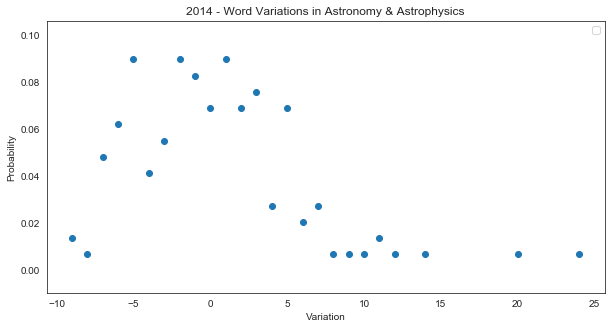

In [33]:
year = 2014

N = 113
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]


variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


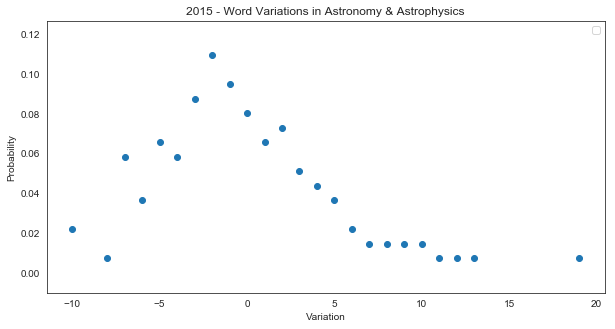

In [34]:
year = 2015

N = 114
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()